In [6]:
import os
import tempfile
import numpy as np
# import keras
# from keras import backend as K
import tensorflow as tf
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam,SGD
from tensorflow.keras.metrics import categorical_crossentropy
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from keras.models import Model
from keras.applications import imagenet_utils
from keras.callbacks import EarlyStopping, ModelCheckpoint,TensorBoard
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D,Input,Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
import tensorflow.keras as keras
import gspread
import pandas as pd
import tensorflow_addons as tfa 
from oauth2client.service_account import ServiceAccountCredentials
%matplotlib inline

In [2]:
import tensorflow as tf

In [3]:
tf.__version__

'2.5.0'

In [4]:
def add_regularization(model, regularizer=keras.regularizers.l2(0.0001)):

    if not isinstance(regularizer, keras.regularizers.Regularizer):
      print("Regularizer must be a subclass of tf.keras.regularizers.Regularizer")
      return model

    for layer in model.layers:
        for attr in ['kernel_regularizer']:
            if hasattr(layer, attr):
              setattr(layer, attr, regularizer)

    # When we change the layers attributes, the change only happens in the model config file
    model_json = model.to_json()

    # Save the weights before reloading the model.
    tmp_weights_path = os.path.join(tempfile.gettempdir(), 'tmp_weights.h5')
    model.save_weights(tmp_weights_path)

    # load the model from the config
    model = keras.models.model_from_json(model_json)
    
    # Reload the model weights
    model.load_weights(tmp_weights_path, by_name=True)
    return model

In [8]:
my_mobilenet = tf.keras.applications.MobileNetV3Small()
# mobile = keras.applications.

In [9]:
mobile = add_regularization(my_mobilenet)
# mobile=my_mobilenet
# mobile.summary()

C:\Users\babba\Anaconda3\envs\objectdetect\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


In [10]:
x = mobile.layers[-2].output
x= tf.keras.layers.Dropout(rate=0.5)(x)
predictions = Dense(9, activation='softmax',kernel_regularizer=tf.keras.regularizers.l2(0.0001))(x)
model = Model(inputs=mobile.input, outputs=predictions)

In [11]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, None, None, 3 0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv (Conv2D)                   (None, None, None, 1 432         rescaling[0][0]                  
__________________________________________________________________________________________________
Conv/BatchNorm (BatchNormalizat (None, None, None, 1 64          Conv[0][0]                       
______________________________________________________________________________________________

In [12]:
pixels = 224
IMAGE_SIZE = (pixels, pixels)
BATCH_SIZE = 32
data_dir=r'D:\sesimic\data'
test_dir=r'D:\sesimic\data_b'

In [13]:


validation_gen = ImageDataGenerator(preprocessing_function = keras.applications.mobilenet_v3.preprocess_input,validation_split=.20)
data_aug=0
if data_aug:
    train_datagen = ImageDataGenerator(
    preprocessing_function = keras.applications.mobilenet_v3.preprocess_input,
    horizontal_flip=True,
    rotation_range=90,
    width_shift_range=0.2, 
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.3,
    validation_split=.20) # set validation split
else:
    train_datagen=validation_gen
    

train_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size= IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    shuffle = True,
    subset="training",
#     color_mode='grayscale'
)

validation_generator = validation_gen.flow_from_directory(
    data_dir, subset="validation",
    target_size= IMAGE_SIZE,
    batch_size=BATCH_SIZE,
#     color_mode='grayscale'
)

test_generator = validation_gen.flow_from_directory(
    test_dir,
    target_size= IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    shuffle = False,
#     color_mode='grayscale'
)

Found 13284 images belonging to 9 classes.
Found 3312 images belonging to 9 classes.
Found 5778 images belonging to 9 classes.


In [22]:
train_generator.n/BATCH_SIZE

415.125

In [14]:


opt = Adam(learning_rate=0.1) #usual optimiser 

opt = tfa.optimizers.MovingAverage(opt)

my_callbacks = [
#     EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5),
    ModelCheckpoint(filepath='./Model/Check Point/model_SGD_m0.5.{epoch:02d}-{val_loss:.2f}-{val_accuracy:.2f}.h5',
                    monitor='val_accuracy',
                    mode='max',
                    verbose=1,
                    save_best_only=True,
                    save_weights_only=False
                   ),
#     TensorBoard(log_dir='../Log/tensorboard/'),
]

model.compile(SGD(learning_rate=.01,momentum=0.5),
             loss='categorical_crossentropy',
             metrics=['accuracy']
             )

In [15]:
%%time
model_history = model.fit(
    train_generator, # steps_per_epoch=1000, # training set / batch_size
    validation_data=validation_generator, # validation_steps=94, # validation set / batch_size
    epochs=100,
    verbose=1,
    callbacks=my_callbacks
)

Epoch 1/100
416/416 [==============================] - 283s 659ms/step - loss: 2.8302 - accuracy: 0.8299 - val_loss: 5.5198 - val_accuracy: 0.4046

Epoch 00001: val_accuracy improved from -inf to 0.40459, saving model to ./Model/Check Point\model_SGD_m0.5.01-5.52-0.40.h5
Epoch 2/100
416/416 [==============================] - 67s 162ms/step - loss: 2.3597 - accuracy: 0.9469 - val_loss: 4.5942 - val_accuracy: 0.6310

Epoch 00002: val_accuracy improved from 0.40459 to 0.63104, saving model to ./Model/Check Point\model_SGD_m0.5.02-4.59-0.63.h5
Epoch 3/100
416/416 [==============================] - 68s 163ms/step - loss: 2.2918 - accuracy: 0.9691 - val_loss: 4.3755 - val_accuracy: 0.6630

Epoch 00003: val_accuracy improved from 0.63104 to 0.66304, saving model to ./Model/Check Point\model_SGD_m0.5.03-4.38-0.66.h5
Epoch 4/100
416/416 [==============================] - 68s 164ms/step - loss: 2.2465 - accuracy: 0.9805 - val_loss: 3.6153 - val_accuracy: 0.7859

Epoch 00004: val_accuracy improve

416/416 [==============================] - 68s 164ms/step - loss: 1.9674 - accuracy: 0.9991 - val_loss: 2.1962 - val_accuracy: 0.9487

Epoch 00037: val_accuracy did not improve from 0.95441
Epoch 38/100
416/416 [==============================] - 58s 138ms/step - loss: 1.9652 - accuracy: 0.9979 - val_loss: 2.1703 - val_accuracy: 0.9502

Epoch 00038: val_accuracy did not improve from 0.95441
Epoch 39/100
416/416 [==============================] - 59s 142ms/step - loss: 1.9572 - accuracy: 0.9980 - val_loss: 2.1116 - val_accuracy: 0.9604

Epoch 00039: val_accuracy improved from 0.95441 to 0.96045, saving model to ./Model/Check Point\model_SGD_m0.5.39-2.11-0.96.h5
Epoch 40/100
416/416 [==============================] - 67s 161ms/step - loss: 1.9476 - accuracy: 0.9993 - val_loss: 2.1335 - val_accuracy: 0.9586

Epoch 00040: val_accuracy did not improve from 0.96045
Epoch 41/100
416/416 [==============================] - 67s 162ms/step - loss: 1.9506 - accuracy: 0.9979 - val_loss: 2.2689 - val

416/416 [==============================] - 68s 164ms/step - loss: 1.7284 - accuracy: 0.9989 - val_loss: 2.0877 - val_accuracy: 0.9176

Epoch 00077: val_accuracy did not improve from 0.96045
Epoch 78/100
416/416 [==============================] - 67s 162ms/step - loss: 1.7176 - accuracy: 0.9995 - val_loss: 1.9931 - val_accuracy: 0.9408

Epoch 00078: val_accuracy did not improve from 0.96045
Epoch 79/100
416/416 [==============================] - 69s 165ms/step - loss: 1.7133 - accuracy: 0.9989 - val_loss: 1.9036 - val_accuracy: 0.9511

Epoch 00079: val_accuracy did not improve from 0.96045
Epoch 80/100
416/416 [==============================] - 68s 164ms/step - loss: 1.7056 - accuracy: 0.9998 - val_loss: 1.8979 - val_accuracy: 0.9529

Epoch 00080: val_accuracy did not improve from 0.96045
Epoch 81/100
416/416 [==============================] - 68s 164ms/step - loss: 1.6999 - accuracy: 0.9998 - val_loss: 1.8900 - val_accuracy: 0.9538

Epoch 00081: val_accuracy did not improve from 0.9604

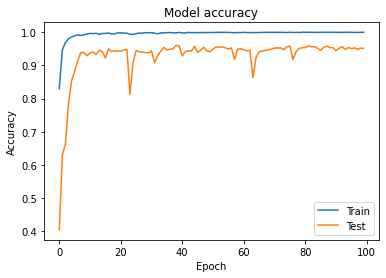

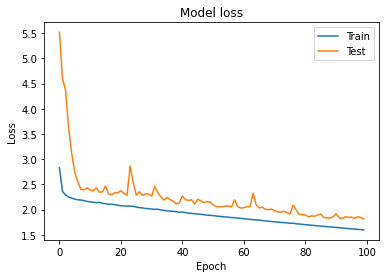

In [16]:
# Plot training & validation accuracy values
plt.plot(model_history.history['accuracy'])
plt.plot(model_history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='best')
# plt.savefig("mobile_net_v2_PA_acc.jpg",bbox_inches='tight')
plt.show()

# Plot training & validation loss values
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='best')
# plt.savefig("mobile_net_v2_PA_loss.jpg",bbox_inches='tight')
plt.show()

In [76]:
model_test=model.load_weights('./Model/Check Point/model.97-0.61-0.96.h5')

In [79]:
model.evaluate(test_generator, verbose=1)

181/181 [==============================] - 48s 241ms/step - loss: 3.1079 - accuracy: 0.7501


[3.1079471111297607, 0.7500865459442139]

In [80]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print('Normalized confusion matrix')
    else:
        print('confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i,j],
                horizontalalignment="center",
                color='white' if cm[i,j] > thresh else 'black')

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('predicted label')

In [81]:
test_label = test_generator.classes
test_label

array([0, 0, 0, ..., 8, 8, 8])

In [82]:
test_prediction = model.predict(test_generator, verbose=1)

181/181 [==============================] - 6s 30ms/step


In [83]:
cm = confusion_matrix(test_label, test_prediction.argmax(axis=1))

confusion matrix, without normalization
[[511  30   4  16  11  20  13  22  15]
 [173 467   0   0   0   0   0   1   1]
 [ 17   1 596  24   0   4   0   0   0]
 [ 94   0   1 534   8   1   0   0   4]
 [ 84   8   0   5 492  48   1   0   4]
 [214   4   0  14   9 388   1   2  10]
 [241   0   0   0   1   1 374   7  18]
 [ 93   5   0   0   2   0   5 492  45]
 [124   0   0   0   2   7   0  29 480]]


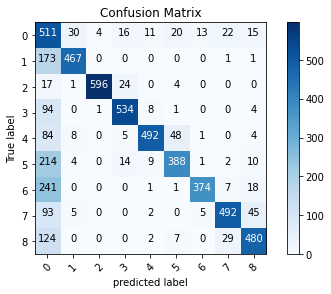

In [84]:
cm_plot_labels = [str(x) for x in range(9)]
confusion=plot_confusion_matrix(cm, cm_plot_labels, title='Confusion Matrix')

# saving to googlesheet

In [18]:
# define the scope
scope = ['https://spreadsheets.google.com/feeds','https://www.googleapis.com/auth/drive']

# add credentials to the account
creds = ServiceAccountCredentials.from_json_keyfile_name('../Archive/sheet-323105-bb560576eed3.json', scope)

# authorize the clientsheet 
client = gspread.authorize(creds)

In [19]:
# get the instance of the Spreadsheet
sheet = client.open('Seismic training')

# get the first sheet of the Spreadsheet
sheet_instance = sheet.get_worksheet(0)

In [6]:
records_data = sheet_instance.get_all_records()


In [20]:
data={'Model Name':'mobilenetv3small','Data Augmentation':'True','[Pixels, Pixels]':str(IMAGE_SIZE),'Training Set':train_generator.n
      ,'Test Set':test_generator.n,'Batch Size':BATCH_SIZE,'Epochs':50,'Steps Per Epoch':train_generator.n/BATCH_SIZE,
      'Time taken':'1h 57min 43s','Training loss':1.9572,'Training Acc':0.9980,'Validation loss':2.1116,
      'Validation Acc':0.9604,'Change implemented':'SGD with momentum=0.5'}
data=pd.DataFrame(data,index=(0,))

In [72]:
loss: 1.9572 - accuracy: 0.9980 - val_loss: 2.1116 - val_accuracy: 0.9604


,Model Name,Data Augmentation,"[Pixels, Pixels]",Training Set,Test Set,Batch Size,Epochs,Steps Per Epoch,Time taken,Training loss,Training Acc,Validation loss,Validation Acc,Change implemented
0,mobilenetv2,True,"(224, 224)",13284,5778,32,50,415.125,1 hour,0.389,0.9995,0.7471,0.9293,first iteration


In [101]:
sheet_instance.insert_rows(data.values.tolist(),3)

{'spreadsheetId': '10zpFlZQ92Pg6uxo4gZyISGEMc3oTh2GT_ugk-pZP4mc',
 'updates': {'spreadsheetId': '10zpFlZQ92Pg6uxo4gZyISGEMc3oTh2GT_ugk-pZP4mc',
  'updatedRange': 'Sheet1!A3:N3',
  'updatedRows': 1,
  'updatedColumns': 14,
  'updatedCells': 14}}

In [95]:
dir(sheet_instance)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_finder',
 '_list_cells',
 '_properties',
 'acell',
 'add_cols',
 'add_protected_range',
 'add_rows',
 'append_row',
 'append_rows',
 'batch_clear',
 'batch_get',
 'batch_update',
 'cell',
 'clear',
 'clear_basic_filter',
 'clear_note',
 'client',
 'col_count',
 'col_values',
 'copy_to',
 'delete_columns',
 'delete_dimension',
 'delete_row',
 'delete_rows',
 'duplicate',
 'export',
 'find',
 'findall',
 'format',
 'freeze',
 'frozen_col_count',
 'frozen_row_count',
 'get',
 'get_all_records',
 'get_all_values',
 'get_note',
 'get_values',
 'id',
 'insert_cols',
 'insert_note',
 'insert_row',
 'insert_rows',
 'merge_cells